In [11]:
import sys
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import os

print(os.getcwd())

sys.path.append('../')  # Adds the parent directory to the Python path

from metabolyton.utils import *

print(sys.path)

/Users/xavierj/Google Drive/xavier_lab_stuff/GitHub/metabolython/Metabolython/examples
['/Users/xavierj/Google Drive/xavier_lab_stuff/GitHub/metabolython/Metabolython/examples', '/Users/xavierj/opt/anaconda3/lib/python39.zip', '/Users/xavierj/opt/anaconda3/lib/python3.9', '/Users/xavierj/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/xavierj/opt/anaconda3/lib/python3.9/site-packages', '/Users/xavierj/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/xavierj/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg', '/Users/xavierj/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/xavierj/.ipython', '/workspaces/Metabolython', '../', '../', '../', '../', '/Users/xavierj/Google Drive/xavier_lab_stuff/GitHub/metabolython/Metabolython/', '/Users/xavierj/Google Drive/xavier_lab_stuff/GitHub/metabolython/Metabolython/', '/Users/xavierj/Google Drive/xavier_lab_stuff/GitHub/metabolython/Metabolython/', '../', '../', '../']


In [12]:
import pandas as pd
from metabolyton.utils import get_compounds_from_module, get_pubchem_id_from_kegg, get_smiles_from_pubchem


def process_module(module_id):
    compound_data = get_compounds_from_module(module_id)
    module_df = pd.DataFrame(columns=['Compound Name', 'KEGG ID', 'PubChem ID', 'SMILES', 'Module'])

    for name, cid in compound_data:
        pubchem_id = get_pubchem_id_from_kegg(cid)
        smiles = get_smiles_from_pubchem(pubchem_id) if pubchem_id else None
        new_row = pd.DataFrame({'Compound Name': [name], 'KEGG ID': [cid], 'PubChem ID': [pubchem_id], 'SMILES': [smiles], 'Module': [module_id]})
        module_df = pd.concat([module_df, new_row], ignore_index=True)
    return module_df
# Process compounds from both modules
glycolysis_df = process_module("M00001")  # Glycolysis
purine_df = process_module("M00048")      # De novo purine biosynthesis

# Concatenate DataFrames
df = pd.concat([glycolysis_df, purine_df], ignore_index=True)

print(df)


Creating directory /Users/xavierj/Library/Caches/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /Users/xavierj/Library/Application Support/bioservices/bioservices.cfg .
Done
                                        Compound Name KEGG ID PubChem ID  \
0                                     alpha-D-Glucose  C00267       3565   
1                         alpha-D-Glucose 6-phosphate  C00668       3937   
2                              D-Fructose 6-phosphate  C00085       3385   
3                         D-Fructose 1,6-bisphosphate  C00354       3647   
4                                 Glycerone phosphate  C00111       3411   
5                        D-Glyceraldehyde 3-phosphate  C00118       3418   
6                     3-Phospho-D-glyceroyl phosphate  C00236       3535   
7                               3-Phospho-D-glycerate  C00197       3497   
8                               2-Phospho-D-glycerate  C00

In [13]:
# Convert SMILES to RDKit Molecule objects
df['Molecule'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

# Generate molecular fingerprints
df['Fingerprint'] = df['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) if x is not None else None)
# from rdkit.Chem import MACCSkeys

# # Generate MACCS fingerprints
# df['Fingerprint'] = df['Molecule'].apply(lambda x: MACCSkeys.GenMACCSKeys(x) if x is not None else None)

# Calculate pairwise Tanimoto distances
num_compounds = len(df)
distance_matrix = np.zeros((num_compounds, num_compounds))

for i in range(num_compounds):
    for j in range(num_compounds):
        if df['Fingerprint'][i] is not None and df['Fingerprint'][j] is not None:
            similarity = DataStructs.FingerprintSimilarity(df['Fingerprint'][i], df['Fingerprint'][j], metric=DataStructs.TanimotoSimilarity)
            distance_matrix[i, j] = 1 - similarity  # Convert similarity to distance
        else:
            distance_matrix[i, j] = np.nan
            
# Convert to DataFrame for better readability
distance_df = pd.DataFrame(distance_matrix, index=df['KEGG ID'], columns=df['KEGG ID'])

print(distance_df)

KEGG ID    C00267    C00668    C00085    C00354    C00111    C00118    C00236  \
KEGG ID                                                                         
C00267   0.000000  0.517241  0.800000  0.829268  0.909091  0.944444  0.947368   
C00668   0.517241  0.000000  0.538462  0.538462  0.714286  0.729730  0.743590   
C00085   0.800000  0.538462  0.000000  0.228571  0.717949  0.761905  0.772727   
C00354   0.829268  0.538462  0.228571  0.000000  0.750000  0.761905  0.772727   
C00111   0.909091  0.714286  0.717949  0.750000  0.000000  0.666667  0.645161   
C00118   0.944444  0.729730  0.761905  0.761905  0.666667  0.000000  0.533333   
C00236   0.947368  0.743590  0.772727  0.772727  0.645161  0.533333  0.000000   
C00197   0.914286  0.694444  0.761905  0.761905  0.620690  0.500000  0.370370   
C00631   0.882353  0.763158  0.790698  0.818182  0.666667  0.727273  0.705882   
C00074   0.970588  0.810811  0.804878  0.804878  0.724138  0.781250  0.677419   
C00022   0.960000  0.939394 

In [14]:
from sklearn.manifold import MDS

# Convert the DataFrame to a NumPy array
distance_matrix = distance_df.to_numpy()

# Initialize and fit MDS
mds = MDS(n_components=2, random_state=42)
mds_coords = mds.fit_transform(distance_matrix)  # shape (n_samples, 2)

# Add the x and y coordinates from mds_coords to df
df['x'] = mds_coords[:, 0]  # x-coordinates
df['y'] = mds_coords[:, 1]  # y-coordinates

print(df)

                                        Compound Name KEGG ID PubChem ID  \
0                                     alpha-D-Glucose  C00267       3565   
1                         alpha-D-Glucose 6-phosphate  C00668       3937   
2                              D-Fructose 6-phosphate  C00085       3385   
3                         D-Fructose 1,6-bisphosphate  C00354       3647   
4                                 Glycerone phosphate  C00111       3411   
5                        D-Glyceraldehyde 3-phosphate  C00118       3418   
6                     3-Phospho-D-glyceroyl phosphate  C00236       3535   
7                               3-Phospho-D-glycerate  C00197       3497   
8                               2-Phospho-D-glycerate  C00631       3904   
9                                 Phosphoenolpyruvate  C00074       3374   
10                                           Pyruvate  C00022       3324   
11             5-Phospho-alpha-D-ribose 1-diphosphate  C00119       3419   
12          

/Users/xavierj/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


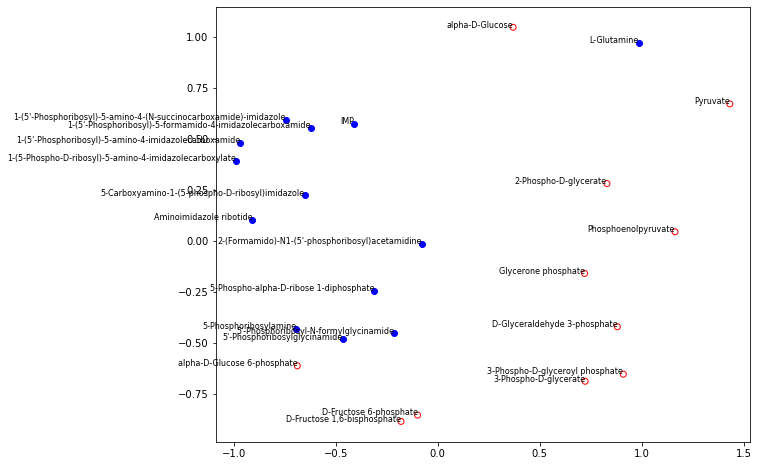

In [18]:
# Create a scatter plot with a bigger size
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each molecule, its name, and a dot
for index, row in df.iterrows():
    
    # Change the color and marker based on the 'Module' value
    if row['Module'] == 'M00001':
        color = 'red'
        marker = 'o'
        facecolor = 'none'
    elif row['Module'] == 'M00048':
        color = 'blue'
        marker = 'o'
        facecolor = 'blue'
    else:
        color = 'black'
        marker = 'o'
        facecolor = 'black'
    # Plot the dot with the specified color and marker
    # Draw the molecule
    draw_molecule_on_plot(ax, row['SMILES'], row['x'], row['y'], scale=0.1)
    
    # Add the compound name next to the dot
    ax.text(row['x'], row['y'], row['Compound Name'], fontsize=8, ha='right')
    ax.scatter(row['x'], row['y'], color=color, marker=marker, facecolor=facecolor)
    

# Set plot limits and aspect if needed
ax.set_xlim(df['x'].min() - 0.1, df['x'].max() + 0.1)
ax.set_ylim(df['y'].min() - 0.1, df['y'].max() + 0.1)
ax.set_aspect('equal', adjustable='box')

plt.show()

In [16]:
# print the row of df corresponding to pyruvate
print(df[df['Compound Name'] == 'Pyruvate'])

   Compound Name KEGG ID PubChem ID        SMILES  Module  \
10      Pyruvate  C00022       3324  CC(=O)C(=O)O  M00001   

                                            Molecule  \
10  <rdkit.Chem.rdchem.Mol object at 0x7f7a08f390b0>   

                                          Fingerprint         x         y  
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1.432423  0.669942  


In [17]:
from metabolyton.utils import get_smiles_from_pubchem
s = get_smiles_from_pubchem('3324')
print(s)
substance = pcp.Substance.from_sid('3324')
print(substance)
substance.synonyms
print(substance.cids)

c = pcp.Compound.from_cid(substance.cids[0])
print(c.isomeric_smiles)
print(c.cid)
#print(compound.iupac_name)

CC(=O)C(=O)O
Substance(3324)
[1060]
CC(=O)C(=O)O
1060
